In [1]:
%load_ext autoreload


In [2]:
%autoreload 2

In [3]:
import pandas as pd
import numpy as np
from scipy import stats
from datetime import datetime
''' Sn properties - Masses, Ratios, Cup Configurations, ... '''
from sn_config import *
'''Classes for Reading in the Data and applying Internal Normalisation'''
from nu_data_reduction import NU_data_read, normalisation, evaluation
import pylab as plt
from scipy import stats
import os.path
import re
#%pylab inline

In [121]:
path = "/Volumes/friebelm/PhD/NU Plasma/Measurements/2015-03-25/"
path_sav = "/Volumes/friebelm/PhD/NU Plasma/Measurements/compilation/"
path_all = "/Volumes/friebelm/PhD/NU Plasma/Measurements/2018-05-15/raw files/"
files_start = 4547
files_end = 4713


In [122]:
# cup configuration
#cup_config = cycle_Sb
cup_config = cycles2
# Isotopes used for Interference correction
corr_isotopes_1 = {"Cd" : "111", "Te" : "125"}
corr_isotopes_2 = {"Cd" : "111","Te" : "125", "Xe" : "129"}
corr_isotopes_Sb = {"Te": "125"}
# Mass Range of cup configuration
mass_range = cycles2_mass_range
#isotopes = [["111", "112", "114", "115", "116", "117", "118", "119", "122", "124"], ["117", "118", "119", "122", "124"]]
isotopes = [["111", "112", "114", "115", "116", "117", "118", "119", "122", "124", "125", "126", "129"]]
#isotopes = [["116", "117", "118", "119", "122", "124"]]
denom_isotope = "120"
isotope_column = ["111", "112", "114", "115", "116", "117", "118", "119", "122", "124", "125", "126", "129"]
data_sample_column = [(i + "/" + "120") for i in isotope_column]
print data_sample_column
#number of iterations for beta
iter_beta = 10

# Interference_corr on the denominator isotope
isotope_denom_corr = True

blk_corr = True

['111/120', '112/120', '114/120', '115/120', '116/120', '117/120', '118/120', '119/120', '122/120', '124/120', '125/120', '126/120', '129/120']


In [123]:
def mad_based_outlier(points, thresh=3.5):
        """
        Returns a boolean array with True if points are outliers and False
        otherwise.

        Parameters:
        -----------
            points : An numobservations by numdimensions array of observations
            thresh : The modified z-score to use as a threshold. Observations with
                a modified z-score (based on the median absolute deviation) greater
                than this value will be classified as outliers.

        Returns:
        --------
            mask : A numobservations-length boolean array.

        References:
        ----------
            Boris Iglewicz and David Hoaglin (1993), "Volume 16: How to Detect and
            Handle Outliers", The ASQC Basic References in Quality Control:
            Statistical Techniques, Edward F. Mykytka, Ph.D., Editor.
        """
        if len(points.shape) == 1:
            points = points[:,None]
        median = np.median(points, axis=0)
        diff = np.sum((points - median)**2, axis=-1)
        diff = np.sqrt(diff)
        med_abs_deviation = np.median(diff)

        modified_z_score = 0.6745 * diff / med_abs_deviation

        return modified_z_score > thresh

#outlier rejection
def mad_outlier_rejection(df):
    data_sample_outlier = pd.DataFrame()
    columns = df.columns.tolist()
    for column in columns:
        data_sample_outlier[column] = df[column].where(~mad_based_outlier(df[column]), other=np.NaN)
    return data_sample_outlier

def mad_outlier(df):
    data_sample_outlier = pd.DataFrame()
    columns = df.columns.tolist()
    for column in columns:
        data_sample_outlier[column] = df[column].where(mad_based_outlier(df[column]), other=np.NaN)
    return data_sample_outlier

In [127]:
filenames = os.listdir(path_all)

In [128]:
sample_ls = []
for i in filenames:
    sample = re.search(r""+"Data_"+"(.*).csv", i)
    if sample == None:
        None
    else:
        sample = sample.group(1)
        df = NU_data_read(path_all, sample, cup_config)
        sample_name = df.extract_metadata(sample, "Sample Name")
        sample_ls.append(sample)

In [129]:
columns = ["cycle", "sample", "date","H10 (Z1)", "H9 (Z1)", "H8 (Z1)", "H7 (Z1)", "H6 (Z1)", "H5 (Z1)", "H4 (Z1)", "H3 (Z1)", "H2 (Z1)", "H1 (Z1)", "Ax (Z1)", "L1 (Z1)", "L2 (Z1)", "L3 (Z1)", "L4 (Z1)"]
#columns = ["cycle", "sample", "date","H10 (1)", "H9 (1)", "H8 (1)", "H7 (1)", "H6 (1)", "H5 (1)", "H4 (1)", "H3 (1)", "H2 (1)", "H1 (1)", "Ax (1)", "L1 (1)", "L2 (1)", "L3 (1)", "L4 (1)"]
df_all = pd.DataFrame(columns = columns)
for sample in sample_ls:
    df = NU_data_read(path_all, sample, cup_config)
    datafile = "Data_" + str(sample) + ".csv"
    data = pd.read_csv(path_all + datafile, skiprows=58, index_col='Cycle')
    
    data_zero = data.ix[:,"H10 (Z1)":"L4 (Z1)"]
    data_zero["cycle"] = data_zero.index.values
        #data_1_corr = mad_outlier_rejection(data_1_corr)
        
    sample_name = df.extract_metadata(sample, "Sample Name")
    date = df.extract_metadata(sample, "Date")
    starttime = df.extract_metadata(sample, "Start Time")
    data_zero["date"] = datetime.strptime(date+starttime, '%d/%m/%Y%H:%M')
    data_zero["sample"] = sample_name
    df_all = pd.concat([df_all,data_zero], axis=0, ignore_index=True)
    #df_all = df_all.append(data_1_corr)
    df_all = df_all[columns]
df_all.set_index("date", inplace = True)
df_all

/Users/marf/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  if __name__ == '__main__':
/Users/marf/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/Users/marf/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.

,cycle,sample,H10 (Z1),H9 (Z1),H8 (Z1),H7 (Z1),H6 (Z1),H5 (Z1),H4 (Z1),H3 (Z1),H2 (Z1),H1 (Z1),Ax (Z1),L1 (Z1),L2 (Z1),L3 (Z1),L4 (Z1)
date,,,,,,,,,,,,,,,,,
2018-05-14 22:13:00,1,blank sol,-0.004771,-0.008027,-0.006573,-0.001905,-0.006125,-0.007097,-0.004001,-0.003529,-0.005581,-0.006652,-0.007658,-0.006422,-0.005502,-0.005541,-0.002848
2018-05-14 22:13:00,2,blank sol,-0.004771,-0.008027,-0.006573,-0.001905,-0.006125,-0.007097,-0.004001,-0.003529,-0.005581,-0.006652,-0.007658,-0.006422,-0.005502,-0.005541,-0.002848
2018-05-14 22:13:00,3,blank sol,-0.004771,-0.008027,-0.006573,-0.001905,-0.006125,-0.007097,-0.004001,-0.003529,-0.005581,-0.006652,-0.007658,-0.006422,-0.005502,-0.005541,-0.002848
2018-05-14 22:13:00,4,blank sol,-0.004771,-0.008027,-0.006573,-0.001905,-0.006125,-0.007097,-0.004001,-0.003529,-0.005581,-0.006652,-0.007658,-0.006422,-0.005502,-0.005541,-0.002848
2018-05-14 22:13:00,5,blank sol,-0.004771,-0.008027,-0.006573,-0.001905,-0.006125,-0.007097,-0.004001,-0.003529,-0.005581,-0.006652,-0.007658,-0.006422,-0.005502,-0.005541,-0.002848
2018-05-14 22:13:00,6,blank sol,-0.004771,-0.008027,-0.006573,-0.001905,-0.006125,-0.007097,-0.004001,-0.003529,-0.005581,-0.006652,-0.007658,-0.006422,-0.005502,-0.005541,-0.002848
2018-05-14 22:13:00,7,blank sol,-0.004771,-0.008027,-0.006573,-0.001905,-0.006125,-0.007097,-0.004001,-0.003529,-0.005581,-0.006652,-0.007658,-0.006422,-0.005502,-0.005541,-0.002848
2018-05-14 22:13:00,8,blank sol,-0.004771,-0.008027,-0.006573,-0.001905,-0.006125,-0.007097,-0.004001,-0.003529,-0.005581,-0.006652,-0.007658,-0.006422,-0.005502,-0.005541,-0.002848
2018-05-14 22:13:00,9,blank sol,-0.004771,-0.008027,-0.006573,-0.001905,-0.006125,-0.007097,-0.004001,-0.003529,-0.005581,-0.006652,-0.007658,-0.006422,-0.005502,-0.005541,-0.002848


In [130]:
def mean(x):
    mean = np.nanmean(x) 
    return mean

df_all_mean = df_all.drop("cycle", axis=1).groupby(df_all.index).agg(mean)
df_all_mean["sample"] = df_all[~df_all.index.duplicated(keep='first')]["sample"]
#df_all_mean.to_csv(path_all+"zeros.csv")
df_all_mean
#df_all_mean[df_all_mean["H2 (Z1)"] >= -0.0058]
#(df_all_mean["H6 (1)"].mean() - (df_all_mean["H4 (1)"].mean()/24.22*32.6))*1000

,H10 (Z1),H9 (Z1),H8 (Z1),H7 (Z1),H6 (Z1),H5 (Z1),H4 (Z1),H3 (Z1),H2 (Z1),H1 (Z1),Ax (Z1),L1 (Z1),L2 (Z1),L3 (Z1),L4 (Z1),sample
date,,,,,,,,,,,,,,,,
2018-05-14 21:36:00,-0.004773,-0.008028,-0.006578,-0.001907,-0.006125,-0.007076,-0.004000,-0.003518,-0.004871,-0.006653,-0.007657,-0.006411,-0.005501,-0.005560,-0.002860,blank sol
2018-05-14 21:42:00,-0.004779,-0.008035,-0.006576,-0.001896,-0.006134,-0.007078,-0.004010,-0.003513,-0.004844,-0.006657,-0.007665,-0.006413,-0.005516,-0.005544,-0.002856,NIST + DS 0.5-0.5 40ppb
2018-05-14 21:54:00,-0.004783,-0.008024,-0.006559,-0.001897,-0.006130,-0.007077,-0.003997,-0.003445,0.051111,-0.006627,-0.007654,-0.006426,-0.005519,-0.005563,-0.002863,blank sol
2018-05-14 22:00:00,-0.004777,-0.008018,-0.006571,-0.001897,-0.006122,-0.007084,-0.004000,-0.003513,-0.005424,-0.006655,-0.007657,-0.006414,-0.005504,-0.005547,-0.002856,NIST + DS 0.5-0.5 40ppb
2018-05-14 22:13:00,-0.004771,-0.008027,-0.006573,-0.001905,-0.006125,-0.007097,-0.004001,-0.003529,-0.005581,-0.006652,-0.007658,-0.006422,-0.005502,-0.005541,-0.002848,blank sol
2018-05-14 22:19:00,-0.004773,-0.008032,-0.006556,-0.001889,-0.006120,-0.007078,-0.003985,-0.003521,-0.004748,-0.006647,-0.007658,-0.006410,-0.005494,-0.005538,-0.002831,NIST + DS 0.5-0.5 40ppb
2018-05-14 22:31:00,-0.004768,-0.008030,-0.006557,-0.001881,-0.006123,-0.007087,-0.003992,-0.003523,-0.005642,-0.006644,-0.007667,-0.006413,-0.005494,-0.005545,-0.002843,blank sol
2018-05-14 22:36:00,-0.004771,-0.008021,-0.006550,-0.001898,-0.006110,-0.007093,-0.003983,-0.003513,-0.005542,-0.006636,-0.007653,-0.006401,-0.005488,-0.005545,-0.002834,NIST + DS 0.5-0.5 40ppb
2018-05-14 22:48:00,-0.004774,-0.008019,-0.006553,-0.001894,-0.006103,-0.007072,-0.003993,-0.003509,-0.005641,-0.006638,-0.007641,-0.006415,-0.005480,-0.005536,-0.002842,blank sol


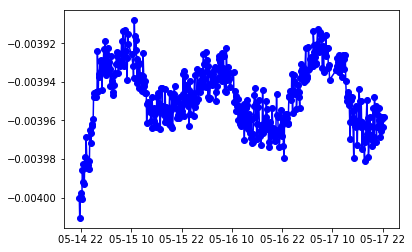

In [140]:
sel_cup = "H4 (Z1)"
#plt.plot(df_all_mean[df_all_mean.index > "2018-05-02"].index, df_all_mean[df_all_mean.index > "2018-05-02"][sel_cup], linestyle='-', marker='o', color='b')
plt.plot(df_all_mean[df_all_mean.index > "2018-05-01"].index, df_all_mean[df_all_mean.index > "2018-05-01"][sel_cup], linestyle='-', marker='o', color='b')
plt.show()

In [132]:
outliers = mad_outlier(df_all_mean.drop("sample", axis=1))
outliers = outliers.dropna(how='all')
dates_outlier = outliers.index.tolist()
samples = df_all_mean.ix[dates_outlier]["sample"]
outliers["sample"] = samples
outliers
#outliers.to_csv(path_all+"outliers_zeros.csv")

/Users/marf/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  after removing the cwd from sys.path.


,H10 (Z1),H9 (Z1),H8 (Z1),H7 (Z1),H6 (Z1),H5 (Z1),H4 (Z1),H3 (Z1),H2 (Z1),H1 (Z1),Ax (Z1),L1 (Z1),L2 (Z1),L3 (Z1),L4 (Z1),sample
date,,,,,,,,,,,,,,,,
2018-05-14 21:36:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.004871,NaN,-0.007657,-0.006411,-0.005501,NaN,NaN,blank sol
2018-05-14 21:42:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.004844,NaN,-0.007665,-0.006413,-0.005516,NaN,NaN,NIST + DS 0.5-0.5 40ppb
2018-05-14 21:54:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.051111,NaN,-0.007654,-0.006426,-0.005519,NaN,NaN,blank sol
2018-05-14 22:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.007657,-0.006414,-0.005504,NaN,NaN,NIST + DS 0.5-0.5 40ppb
2018-05-14 22:13:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.003529,NaN,NaN,-0.007658,-0.006422,-0.005502,NaN,NaN,blank sol
2018-05-14 22:19:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.004748,NaN,-0.007658,-0.006410,-0.005494,NaN,NaN,NIST + DS 0.5-0.5 40ppb
2018-05-14 22:31:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.007667,-0.006413,-0.005494,NaN,NaN,blank sol
2018-05-14 22:36:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.007653,NaN,-0.005488,NaN,NaN,NIST + DS 0.5-0.5 40ppb
2018-05-14 22:48:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.006415,NaN,NaN,NaN,blank sol


In [133]:
outlier_corr = mad_outlier_rejection(df_all_mean.drop("sample", axis=1))
outlier_corr
#outlier_corr.to_csv(path_all+"zeros_outlier_corr.csv")

,H10 (Z1),H9 (Z1),H8 (Z1),H7 (Z1),H6 (Z1),H5 (Z1),H4 (Z1),H3 (Z1),H2 (Z1),H1 (Z1),Ax (Z1),L1 (Z1),L2 (Z1),L3 (Z1),L4 (Z1)
date,,,,,,,,,,,,,,,
2018-05-14 21:36:00,-0.004773,-0.008028,-0.006578,-0.001907,-0.006125,-0.007076,-0.004000,-0.003518,NaN,-0.006653,NaN,NaN,NaN,-0.005560,-0.002860
2018-05-14 21:42:00,-0.004779,-0.008035,-0.006576,-0.001896,-0.006134,-0.007078,-0.004010,-0.003513,NaN,-0.006657,NaN,NaN,NaN,-0.005544,-0.002856
2018-05-14 21:54:00,-0.004783,-0.008024,-0.006559,-0.001897,-0.006130,-0.007077,-0.003997,-0.003445,NaN,-0.006627,NaN,NaN,NaN,-0.005563,-0.002863
2018-05-14 22:00:00,-0.004777,-0.008018,-0.006571,-0.001897,-0.006122,-0.007084,-0.004000,-0.003513,-0.005424,-0.006655,NaN,NaN,NaN,-0.005547,-0.002856
2018-05-14 22:13:00,-0.004771,-0.008027,-0.006573,-0.001905,-0.006125,-0.007097,-0.004001,NaN,-0.005581,-0.006652,NaN,NaN,NaN,-0.005541,-0.002848
2018-05-14 22:19:00,-0.004773,-0.008032,-0.006556,-0.001889,-0.006120,-0.007078,-0.003985,-0.003521,NaN,-0.006647,NaN,NaN,NaN,-0.005538,-0.002831
2018-05-14 22:31:00,-0.004768,-0.008030,-0.006557,-0.001881,-0.006123,-0.007087,-0.003992,-0.003523,-0.005642,-0.006644,NaN,NaN,NaN,-0.005545,-0.002843
2018-05-14 22:36:00,-0.004771,-0.008021,-0.006550,-0.001898,-0.006110,-0.007093,-0.003983,-0.003513,-0.005542,-0.006636,NaN,-0.006401,NaN,-0.005545,-0.002834
2018-05-14 22:48:00,-0.004774,-0.008019,-0.006553,-0.001894,-0.006103,-0.007072,-0.003993,-0.003509,-0.005641,-0.006638,-0.007641,NaN,-0.005480,-0.005536,-0.002842


In [ ]:
df_all.to_csv(path_all + "blanks.csv", mode='w', header=True)

In [18]:
df_all_mean.to_csv(path_all + "blanks_mean.csv", mode='w', header=True)

In [229]:
df_internal_norm_mean_sd.to_csv(path + "Sn_H8_L4_2_cycles_internal_norm_mean_no_bgd_corr.csv")

In [389]:
epsilon.to_csv(path + "Sn_H8_L4_2_cycles_internal_norm_epsilon_bgd_corr.csv")